# Projected quantum kernels

The tutorial presents the implementation of the projected quantum kernel approach by Huang et al. (2021) [1].

[1] Huang, H.-Y.; Broughton, M.; Mohseni, M.; Babbush, R.; Boixo, S.; Neven, H.; McClean, J. R. Power of Data in Quantum Machine Learning. Nat Commun 2021, 12 (1), 2631. https://doi.org/10.1038/s41467-021-22539-9

In [1]:
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics

from common import generate_moons_dataset
from common import visualize_decision_boundaries
from common import print_scores

from qksvm.QKSVC import QKSVC
from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qksvm.ProjectedQuantumKernel import ProjectedQuantumKernel

seed = 12345

# Dataset

The [moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) is chosen for the demonstration purposes.
This dataset has non-trivial and non-linear decision boundaries such that no separating hyperplane could be found to perfectly split 2 data classes.

Following the standard machine learning (ML) practice, we generate 2 independent datasets. The first dataset (`X_train`=($x_1$, $x_2$) - the 2d cartesian coordinates, and `y_train`={0, 1} - the datapoint labels) is used for training the chosen model and optimizing the model hyperparameters.
The second dataset `(X_test, y_test)` serves to crosscheck the accuracy of the model on previously unseen datapoints (thus testing the model generalization performance).

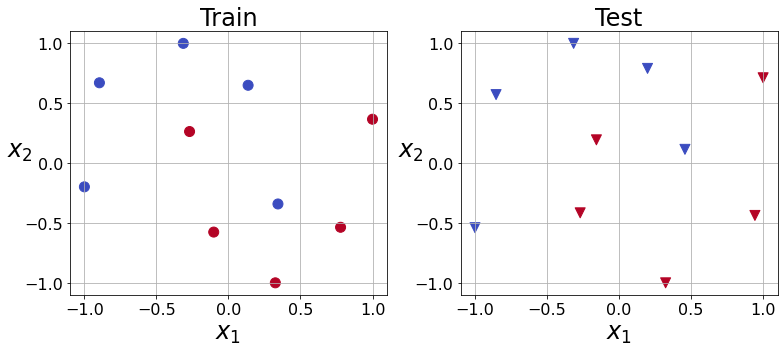

(10, 2)
(10, 2)


In [2]:
X_train, y_train, X_test, y_test = generate_moons_dataset()
print(X_train.shape)
print(X_test.shape)

# Quantum Kernel Estimation algorithm

For comparison, the classification problem is first solved with the Quantum Kernel Estimate (QKE) SVC algorithm.
The main idea of this algorithm is to use a quantum computer to encode classical data into quantum states.
The kernel matrix elements are estimated as the fidelity (or overlap) between pairs of the encoded quantum states.

     ┌──────────────┐                 ┌──────────────┐ 
q_0: ┤ Rx(π/2*x[0]) ├────────■────────┤ Ry(π/2*x[1]) ├─
     ├──────────────┤ ┌──────┴───────┐└──────┬───────┘ 
q_1: ┤ Rx(π/2*x[1]) ├─┤ Ry(π/2*x[0]) ├───────■─────────
     └──────────────┘ └──────────────┘                 

Prediction Scores:

		Train	Test
Accuracy:	0.80	0.80
 ROC_AUC:	0.80	0.80



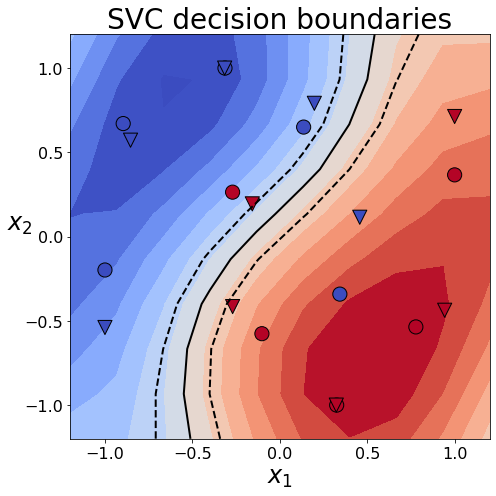

In [6]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    alpha=np.pi/2,
    gates=['RX', 'CRY'], entanglement='ring',
)
print(fm.draw(plot_barriers=False, fold=150))

clf = QKSVC(feature_map=fm, C=1.0, random_state=seed)

clf.fit(X_train, y_train)
print_scores(clf, X_train, y_train, X_test, y_test)
visualize_decision_boundaries(clf, X_train, y_train, X_test, y_test)

# Projected Quantum Embedding

Similarly to QKE, in the projected quantum kernel approach, the classical datapoints are mapped to the quantum states.
However, as a next step, these quantum states are projected back into the classical representation. 
For this, the expectaction values of some (random) single qubit projection operators are computed on the quantum computer.
The SVC algorithm is then applied to the transformed classical data with a specialized kernel function.

In the tutorial we keep the quantum feature map circuit fixed and apply two types of projections.
With `projection="xyz_sum"`, the algorithm projects the encoded quantum states on the sum of the Pauli operators `X+Y+Z` separately for each qubit.
With this projection we do not change the dimensionality of the dataset and compute the projected kernel in the 2d space.

     ┌──────────────┐                 ┌──────────────┐ 
q_0: ┤ Rx(π/2*x[0]) ├────────■────────┤ Ry(π/2*x[1]) ├─
     ├──────────────┤ ┌──────┴───────┐└──────┬───────┘ 
q_1: ┤ Rx(π/2*x[1]) ├─┤ Ry(π/2*x[0]) ├───────■─────────
     └──────────────┘ └──────────────┘                 

Prediction Scores:

		Train	Test
Accuracy:	1.00	1.00
 ROC_AUC:	1.00	1.00



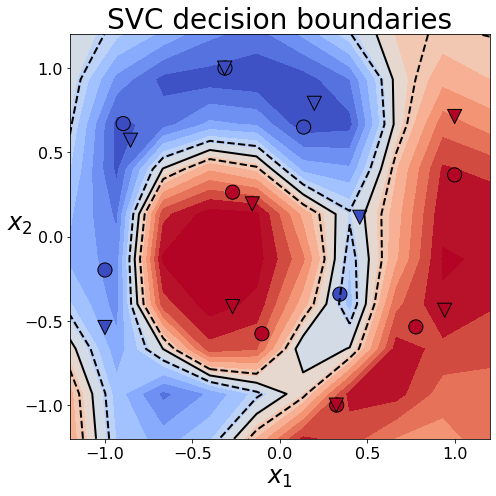

In [4]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    alpha=np.pi/2,
    gates=['RX', 'CRY'], entanglement='ring',
)
print(fm.draw(plot_barriers=False, fold=150))

proj_kernel = ProjectedQuantumKernel(fm, gamma=2.0, projection='xyz_sum', random_state=seed)

clf = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)

clf.fit(X_train, y_train)
print_scores(clf, X_train, y_train, X_test, y_test)
visualize_decision_boundaries(clf, X_train, y_train, X_test, y_test)

As we can see, the usage of the projected kernel improves the SVC score over the QKE results. 
Let us try with another projection, where we collect the expectation values of the `X`, `Y`, and `Z` Pauli operators separately for each qubit. In this way we increase the projected data dimensionality from 2 to 6. 

     ┌──────────────┐                 ┌──────────────┐ 
q_0: ┤ Rx(π/2*x[0]) ├────────■────────┤ Ry(π/2*x[1]) ├─
     ├──────────────┤ ┌──────┴───────┐└──────┬───────┘ 
q_1: ┤ Rx(π/2*x[1]) ├─┤ Ry(π/2*x[0]) ├───────■─────────
     └──────────────┘ └──────────────┘                 

Prediction Scores:

		Train	Test
Accuracy:	1.00	1.00
 ROC_AUC:	1.00	1.00



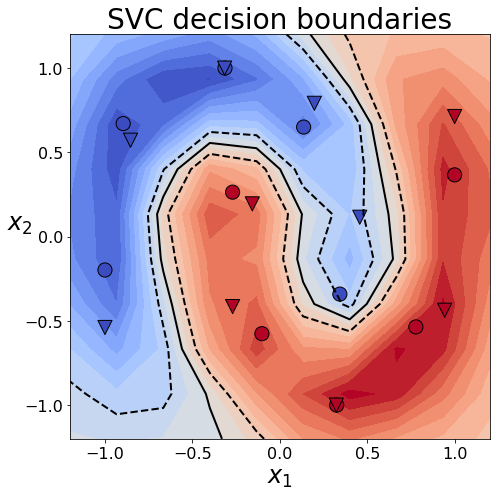

In [5]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    alpha=np.pi/2,
    gates=['RX', 'CRY'], entanglement='ring',
)
print(fm.draw(plot_barriers=False, fold=150))

proj_kernel = ProjectedQuantumKernel(fm, gamma=2.0, projection='xyz', random_state=seed)
clf = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)

clf.fit(X_train, y_train)
print_scores(clf, X_train, y_train, X_test, y_test)
visualize_decision_boundaries(clf, X_train, y_train, X_test, y_test)

Although the accuracy scores have the same values as for the `projection="xyz_sum"`, the decision boundaries are perfectly reproducing the "moons" shape we are expecting.